## Case 2 - movie recommender system

1. Przegląd danych:

   * Podaj liczbę filmów Sci-Fi
   * Pokaż rozkład ocen komedii
   * Podaj średnią ocen wszystkich filmów akcji oraz 3 filmy najwyżej ocenianych





2. System rekomendacyjny

   * Zbuduj system na podstawie algorytmu SVD oraz kNNwithMeans
   * Czym różni się algorytm kNN with means od standardowego kNN?
   * Wykorzystaj metodę hiperparametryzacji GridSearch do wyboru liczby sąsiadów od 2-6
   * W ocenie metod wykorzystaj walidację krzyżową

3. Podaj rekomendacje po obejrzeniu filmu: Jumanji  oraz Flint


**[Ogólny przegląd danych](#Ogólny-przegląd-danych)**
<br>
  *  [1. Liczba filmów Sci-Fi](#1.-Liczba-filmów-Sci-Fi)
<br>
  *  [2. Pokaż rozkład ocen komedii](#2.-Pokaż-rozkład-ocen-komedii)
<br>
  *  [3. Podaj średnią ocen wszystkich filmów akcji oraz 3 filmy najwyżej ocenianych](#3.-Podaj-średnią-ocen-wszystkich-filmów-akcji-oraz-3-filmy-najwyżej-ocenianych)
<br>

**[System rekomendacyjny](#System-rekomendacyjny)**
 <br>
  * [Znajdź ID filmu po tytule](#Znajdź-ID-filmu-po-tytule)
 <br>
  * [Cross-Validation](#Cross-Validation)
 <br>
  * [Hiperparametryzacja](#Hiperparametryzacja)
 <br>
  * [SVD](#SVD)
 <br>
  * [kNNwithMeans](#kNNwithMeans)
 <br>
  * [Różnica między kNNWithMeans a standardowym kNN](#Różnica-między-kNNWithMeans-a-standardowym-kNN)
  <br>
  * [Podsumowanie](#Podsumowanie)


## Biblioteki

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, KNNWithMeans
from surprise.dataset import DatasetAutoFolds
from surprise import (
    Dataset,
    Reader,
    accuracy,
)

from sklearn.metrics.pairwise import cosine_similarity


from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.max_colwidth', None) #  show full title
pd.set_option('display.max_columns', None)  # display any number of columns
pd.set_option('display.expand_frame_repr', False)  # prevent line breaking
pd.set_option('max_colwidth', 1)  # display full column content

In [2]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

### Ogólny przegląd danych

In [3]:
print("\nCałkowita liczba ocen :",ratings.shape[0])
print("Całkowita liczba użytkowników   :", len(np.unique(ratings.userId)))
print("Całkowita liczba filmów  :", len(np.unique(movies.movieId)))


Całkowita liczba ocen : 100836
Całkowita liczba użytkowników   : 610
Całkowita liczba filmów  : 9742


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.describe().round(2)

,userId,movieId,rating,timestamp
count,100836.00,100836.00,100836.00,1.008360e+05
mean,326.13,19435.30,3.50,1.205946e+09
std,182.62,35530.99,1.04,2.162610e+08
min,1.00,1.00,0.50,8.281246e+08
25%,177.00,1199.00,3.00,1.019124e+09
50%,325.00,2991.00,3.50,1.186087e+09
75%,477.00,8122.00,4.00,1.435994e+09
max,610.00,193609.00,5.00,1.537799e+09


In [7]:
movies.describe().round(2)

,movieId
count,9742.00
mean,42200.35
std,52160.49
min,1.00
25%,3248.25
50%,7300.00
75%,76232.00
max,193609.00


In [8]:
# Oddzielanie gatunków jako nowe kolumny
genres = movies['genres'].str.get_dummies(sep='|')

movies = pd.concat([movies, genres], axis=1)

movies.head()


,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 1. Liczba filmów Sci-Fi

 liczba filmów Sci-Fi = `980`

In [9]:
sci_fi_count = movies['Sci-Fi'].sum()
sci_fi_count

980

#### 2. Pokaż rozkład ocen komedii

In [10]:
# filtrowanie komedii
comedy_movies = movies[movies['Comedy'] == 1]
# łączenie z ocenami
comedy_ratings = ratings[ratings['movieId'].isin(movies[movies['Comedy'] == 1]['movieId'])]

Text(0, 0.5, 'Liczba filmów')

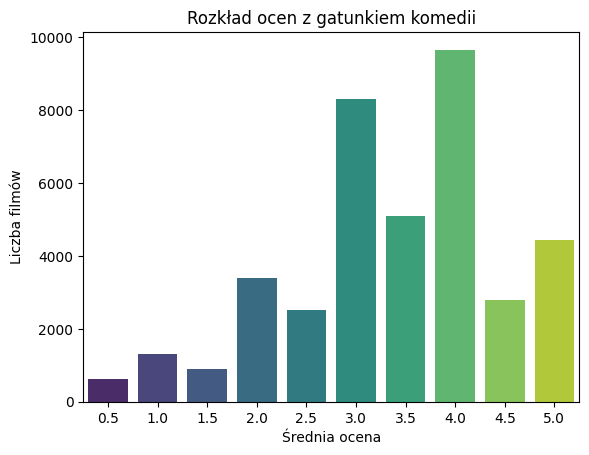

In [11]:
sns.countplot(comedy_ratings, x = 'rating', palette='viridis')
plt.title('Rozkład ocen z gatunkiem komedii')
plt.xlabel('Średnia ocena')
plt.ylabel('Liczba filmów')

#### 3. Podaj średnią ocen wszystkich filmów akcji oraz 3 filmy najwyżej ocenianych

In [12]:
# filtrowanie filmów akcji
action_movies = movies[movies['Action'] == 1]
# łączenie z ocenami
action_ratings = ratings[ratings['movieId'].isin(movies[movies['Action'] == 1]['movieId'])]
action_ratings

,userId,movieId,rating,timestamp
2,1,6,4.0,964982224
5,1,70,3.0,964982400
7,1,110,4.0,964982176
8,1,151,5.0,964984041
10,1,163,5.0,964983650
...,...,...,...,...
100826,610,162350,3.5,1493849971
100830,610,166528,4.0,1493879365
100832,610,168248,5.0,1493850091
100834,610,168252,5.0,1493846352


In [13]:
print(f"Średnia ocen wszystkich filmów akcji: {action_ratings.rating.mean().round(2)}")

Średnia ocen wszystkich filmów akcji: 3.45


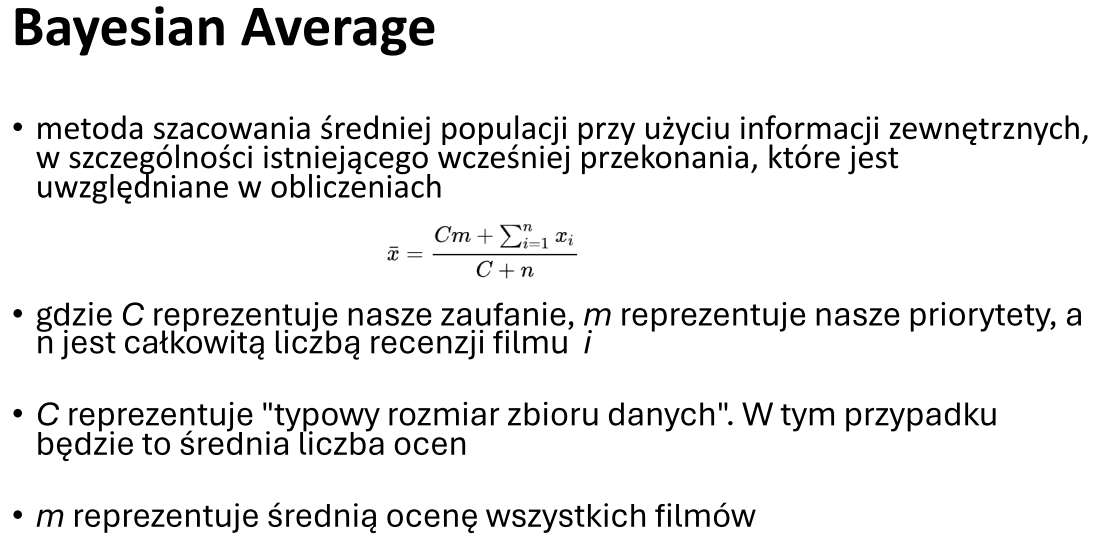

Zwykła średnia nie będzie miarodajna ze względu na różną liczbę ocen, jakie dany film otrzymał.

#### Filmy najwyżej oceniane

In [14]:
# filmy najwyzej oceniane
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429
...,...,...
193581,1,4.000000
193583,1,3.500000
193585,1,3.500000


In [15]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

top_rated_movies = movie_stats.sort_values(by='bayesian_avg', ascending=False).head(3)
top_rated_titles = top_rated_movies.merge(movies[['movieId', 'title']], on='movieId')

# Wybieranie tylko kolumn 'title' i 'bayesian_avg'
top_rated_titles = top_rated_titles[['title', 'bayesian_avg']]

print(f'Najwyżej oceniane 3 filmy:\n{top_rated_titles.round(2)}')

Najwyżej oceniane 3 filmy:
                              title  bayesian_avg
0  Shawshank Redemption, The (1994)  4.39        
1  Godfather, The (1972)             4.24        
2  Fight Club (1999)                 4.23        


   ***Najwyżej oceniane 3 filmy*** 
   
|             Title              | Bayesian Average |
|--------------------------------|------------------|
| Shawshank Redemption, The (1994) |       4.39       |
|       Godfather, The (1972)      |       4.24       |
|         Fight Club (1999)        |       4.23       |

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExY3RvOGtma3k0cDcyc3AzcXBpejJ4emFrc254ZWFkMGNxMmk4dGFtYiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/z9EaObbaU7pS4zFl6d/giphy.gif" width="350" align="center">


In [16]:
# filmy akcji

merged_data = pd.merge(ratings, movies, on='movieId')

action_movies_ratings = merged_data[merged_data['Action'] == 1].groupby('movieId')['rating'].agg(['count', 'mean'])

C = action_movies_ratings['count'].mean()
m = action_movies_ratings['mean'].mean()

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = action_movies_ratings.merge(bayesian_avg_ratings, on='movieId')
movie_stats.describe()

top_rated_movies = movie_stats.sort_values(by='bayesian_avg', ascending=False).head(3)
top_rated_titles = top_rated_movies.merge(movies[['movieId', 'title']], on='movieId')

top_rated_titles = top_rated_titles[['title', 'bayesian_avg']]

print(f'Najwyżej oceniane 3 filmy akcji:\n{top_rated_titles.round(2)}')


Najwyżej oceniane 3 filmy akcji:
                                                   title  bayesian_avg
0  Fight Club (1999)                                      4.19        
1  Star Wars: Episode IV - A New Hope (1977)              4.16        
2  Star Wars: Episode V - The Empire Strikes Back (1980)  4.13        


***Najwyżej oceniane 3 filmy akcji*** 
| Title | Bayesian Average |
|-----------------------------|------------------|
| Fight Club (1999) | 4.19 |
| Star Wars: Episode IV - A New Hope (1977) | 4.16 |
| Star Wars: Episode V - The Empire Strikes Back (1980) | 4.13 |

## System rekomendacyjny

[SVD](#SVD)
<br>
[kNNwithMeans](#kNNwithMeans)

#### Zbuduj system na podstawie algorytmu SVD oraz kNNwithMeans

##### Znajdź ID filmu po tytule

In [108]:
def get_movie_ids_by_title(title_partial, movies = movies):
    """
    This function takes a partial movie title and a DataFrame containing movie titles and IDs,
    and returns a DataFrame of all movies that contain the partial title in their full title.

    Args:
        title_partial (str): The partial movie title.
        movies_df (DataFrame): A DataFrame containing 'movieId' and 'title' columns.

    Returns:
        DataFrame: A DataFrame containing the 'movieId' and 'title' of all movies that contain 
                   the partial title in their full title. If no such movie is found, returns an empty DataFrame.
    """
    # Use the str.contains method to find rows where the title contains the partial title (case insensitive)
    matching_movies = movies[movies['title'].str.contains(title_partial, case=False)]

    # Return the matching_movies DataFrame
    return matching_movies


In [18]:
get_movie_ids_by_title("Star Wars", movies)

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
898,1196,Star Wars: Episode V - The Empire Strikes Back (1980),Action|Adventure|Sci-Fi,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
911,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1979,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3832,5378,Star Wars: Episode II - Attack of the Clones (2002),Action|Adventure|Sci-Fi|IMAX,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
5896,33493,Star Wars: Episode III - Revenge of the Sith (2005),Action|Adventure|Sci-Fi,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6823,61160,Star Wars: The Clone Wars (2008),Action|Adventure|Animation|Sci-Fi,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7367,79006,Empire of Dreams: The Story of the 'Star Wars' Trilogy (2004),Documentary,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8683,122886,Star Wars: Episode VII - The Force Awakens (2015),Action|Adventure|Fantasy|Sci-Fi|IMAX,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
8908,135216,The Star Wars Holiday Special (1978),Adventure|Children|Comedy|Sci-Fi,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [109]:
get_movie_ids_by_title("Jumanji", movies)

,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy
9636,179401,Jumanji: Welcome to the Jungle (2017),Action|Adventure|Children


In [110]:
get_movie_ids_by_title("Flint", movies)

,movieId,title,genres
313,355,"Flintstones, The (1994)",Children|Comedy|Fantasy
2662,3564,"Flintstones in Viva Rock Vegas, The (2000)",Children|Comedy
3909,5493,In Like Flint (1967),Action|Adventure|Comedy
3910,5497,Our Man Flint (1965),Adventure|Comedy|Sci-Fi
8717,126088,A Flintstones Christmas Carol (1994),Animation|Children|Comedy
9739,193585,Flint (2017),Drama


In [111]:
ratings.loc[ratings['movieId'] ==193585]


,userId,movieId,rating,timestamp
27258,184,193585,3.5,1537109805


##### Przegląd ocen i użytkowników

In [112]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [113]:
# Liczba ocen wystawionych przez danego użytkownika

n_rated_movies_per_user = ratings.groupby(by='userId')['rating'].count().sort_values(ascending=False)

n_rated_movies_per_user.head()

userId
414    2698
599    2478
474    2108
448    1864
274    1346
Name: rating, dtype: int64

In [114]:
# Usunięcie zbędnej kolumny 
ratings.drop(columns=['timestamp'], inplace=True)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [24]:
print('\n Liczba ocenionych filmów przekracza 40 na użytkownika : {}\n'.format(sum(n_rated_movies_per_user >= 40)) )



 Liczba ocenionych filmów przekracza 40 na użytkownika : 428



In [25]:
print('\n Liczba ocenionych filmów nie przekracza 20 na użytkownika : {}\n'.format(sum(n_rated_movies_per_user <= 20)) )



 Liczba ocenionych filmów nie przekracza 20 na użytkownika : 14



In [26]:
# sprawdzenie filmów z największą liczbą ocen
top_movies = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head()

for movie_id, rating_count in top_movies.items():
    movie_title = movies.loc[movies['movieId'] == movie_id, 'title'].iloc[0]
    print(f"Film ID: {movie_id}, Tytuł: {movie_title}, Liczba ocen: {rating_count}")

Film ID: 356, Tytuł: Forrest Gump (1994), Liczba ocen: 329
Film ID: 318, Tytuł: Shawshank Redemption, The (1994), Liczba ocen: 317
Film ID: 296, Tytuł: Pulp Fiction (1994), Liczba ocen: 307
Film ID: 593, Tytuł: Silence of the Lambs, The (1991), Liczba ocen: 279
Film ID: 2571, Tytuł: Matrix, The (1999), Liczba ocen: 278


In [27]:
# filmy z najniższą liczbą ocen
down_movies = ratings.groupby('movieId')['rating'].count().sort_values(ascending=True).head()
down_movies
for movie_id, rating_count in down_movies.items():
    movie_title = movies.loc[movies['movieId'] == movie_id, 'title'].iloc[0]
    print(f"Film ID: {movie_id}, Tytuł: {movie_title}, Liczba ocen: {rating_count}")


Film ID: 193609, Tytuł: Andrew Dice Clay: Dice Rules (1991), Liczba ocen: 1
Film ID: 4032, Tytuł: Everlasting Piece, An (2000), Liczba ocen: 1
Film ID: 57526, Tytuł: Untraceable (2008), Liczba ocen: 1
Film ID: 57522, Tytuł: First Sunday (2008), Liczba ocen: 1
Film ID: 57502, Tytuł: Cat Soup (Nekojiru-so) (2001), Liczba ocen: 1


In [28]:
# Zliczanie liczby ocen dla każdego filmu
movie_ratings_counts = ratings['movieId'].value_counts()

# Zliczanie filmów z 1,2 i 3 ocenami
movies_with_one_rating = (movie_ratings_counts == 1).sum()
movies_with_two_ratings = (movie_ratings_counts == 2).sum()
movies_with_three_ratings = (movie_ratings_counts == 3).sum()

print(f"Liczba filmów z 1 oceną: {movies_with_one_rating}")
print(f"Liczba filmów z 2 ocenami: {movies_with_two_ratings}")
print(f"Liczba filmów z 3 ocenami: {movies_with_three_ratings}")


Liczba filmów z 1 oceną: 3446
Liczba filmów z 2 ocenami: 1298
Liczba filmów z 3 ocenami: 800


In [29]:
print(((movies_with_two_ratings/len(merged_data['movieId']))*100).round(3))

1.287


Filmy z jedną oceną stanowią $1.29\%$ całego zbioru. 

`SVD` jest w stanie poradzić sobie z tym, jednak mogą one wprowadzać 'szum'.

In [30]:
# Sprawdzenie czy tytuły filmów się powtarzają
duplicates = movies[movies.duplicated(subset=['title'], keep=False)]
if duplicates.empty:
    print("Nie ma powtarzających się tytułów filmów.")
else:
    print("Powtarzające się tytuły filmów:")
    print(duplicates[['title']])


Powtarzające się tytuły filmów:
                                       title
650   Emma (1996)                           
2141  Saturn 3 (1980)                       
4169  Confessions of a Dangerous Mind (2002)
5601  Emma (1996)                           
5854  Eros (2004)                           
5931  War of the Worlds (2005)              
6932  War of the Worlds (2005)              
9106  Confessions of a Dangerous Mind (2002)
9135  Eros (2004)                           
9468  Saturn 3 (1980)                       


In [31]:
# Sprawdzenie czy ID filmów się powtarzają
duplicates_id = movies[movies.duplicated(subset=['movieId'], keep=False)]
if duplicates_id.empty:
    print("Nie ma powtarzających się ID filmów.")
else:
    print("Powtarzające się ID filmów:")
    print(duplicates_id[['movieId']])


Nie ma powtarzających się ID filmów.


Kilka filmów ma ten sam tytuł ale inne ID. Zostawiam powtarzające się tytuły.

##### Wstępne przygotowanie danych do biblioteki 'Surprise'

In [115]:
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# train_set, test_set = train_test_split(data, test_size=0.25, random_state=0)
trainset = data.build_full_trainset()

## Cross-Validation

In [116]:
# train and fit SVD model
svd = SVD()
svd.fit(trainset)

In [118]:
# train and fit KNNWithMeans model
kNNmean = KNNWithMeans()
kNNmean.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [179]:
benchmark = []
# iterate over all algorithms
for algorithm in [svd, kNNmean]:

    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    
    # get results & create a new DF row
    algorithm_name = str(algorithm).split(' ')[0].split('.')[-1]
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp['Algorithm'] = algorithm_name
    benchmark.append(tmp)
    
# create a DF from the benchmark list
benchmark_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
benchmark_df


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.868750,0.666652,0.815721,0.040610
KNNWithMeans,0.893093,0.681986,0.179892,0.507646


#### Hiperparametryzacja

In [195]:
# Hyperparameter tuning - KNNWithMeans
param_grid = {
    'k': [2, 3, 4, 5, 6],
    'sim_options': {
        'name': ['cosine', 'pearson', 'pearson_baseline'],
        'user_based': [True, False],
    }
}


grid_search_KNNWithMeans = GridSearchCV(KNNWithMeans, param_grid, measures=['mae', 'rmse'], \
                                      cv=5, n_jobs=-1)
                                    
grid_search_KNNWithMeans.fit(data)

print(f'MAE Best Parameters:  {grid_search_KNNWithMeans.best_params["mae"]}')
print(f'MAE Best Score:       {grid_search_KNNWithMeans.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {grid_search_KNNWithMeans.best_params["rmse"]}')
print(f'RMSE Best Score:      {grid_search_KNNWithMeans.best_score["rmse"]}\n')

MAE Best Parameters:  {'k': 6, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}
MAE Best Score:       0.6892054000257396

RMSE Best Parameters: {'k': 6, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}
RMSE Best Score:      0.9080711754677658



In [198]:
params = grid_search_KNNWithMeans.best_params['mae']

In [40]:
# train and fit KNNWithMeans model with hyperparameters
kNNmean = KNNWithMeans(params)
kNNmean.fit(trainset)

NameError: name 'params' is not defined

### SVD

In [68]:
# #USER-BASED
# def get_recommendations_svd(ratings_df, movies_df, n, movie_id):
#     """
#     Generates movie recommendations for users based on their ratings using the SVD algorithm.
    
#     This function is user-focused. It takes a movie ID and recommends other movies that might be liked 
#     by users who rated the given movie highly. 
#     It does this by predicting ratings for all users for the given movie, selecting the users who 
#     have the highest predicted ratings, and then recommending other movies that these users have rated highly.
    
#     Args:
#         ratings_df: pandas DataFrame containing user ratings for movies, containing 'userId', 'movieId', 'rating' columns
#         movies_df: pandas DataFrame containing information about movies, containing 'movieId', 'title' columns
#         n: number of films to be recommended
#         movie_id: identifier of the film for which recommendations are generated

#     Returns:
#         recommended_titles: List of titles of recommended films
#     """
   
#     # Create a Surprise reader and load data
#     reader = Reader(rating_scale=(0.5, 5))
#     data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

#     # Build the trainset
#     trainset = data.build_full_trainset()

#     # Initialize the SVD model
#     model = SVD(random_state=0)

#     # Fit the model to the data
#     model.fit(trainset)

#     # Get movie title and genres for the selected movie
#     movie_info = movies_df[movies_df['movieId'] == movie_id]
#     movie_title = movie_info['title'].values[0]
#     movie_genres = movie_info['genres'].values[0]

#     # Create a DataFrame with all user IDs and the given movie ID
#     all_user_ids = ratings_df['userId'].unique()
#     users_who_rated_movie = pd.DataFrame({
#         'userId': all_user_ids,
#         'movieId': [movie_id] * len(all_user_ids),
#         'rating': [0] * len(all_user_ids)
#     })

#     # Predict ratings for users who have rated the given movie
#     users_who_rated_movie['predicted_rating'] = users_who_rated_movie['userId'].apply(
#         lambda x: model.predict(x, movie_id).est
#     )

#     # Sort users by predicted ratings
#     recommended_users = users_who_rated_movie.sort_values(by='predicted_rating', ascending=False).head(n)

#     # Get recommended movie titles (excluding the input movie)
#     recommended_titles = ratings_df[
#         (ratings_df['userId'].isin(recommended_users['userId'])) & (ratings_df['movieId'] != movie_id)
#     ].merge(movies_df, on='movieId')['title'].unique()[:n]

#     return recommended_titles


In [119]:
def get_similar_movies_svd(movie_id, n):
    
    """
    Finds other movies that are similar to the given movie based on their latent factors in the SVD model.
    
    This function is item-focused. It takes a movie ID and finds other movies that are similar to the given 
    movie based on their latent factors in the SVD model. 
    It computes the cosine similarity between the latent factors of the given movie and all other movies, 
    and returns the movies with the highest similarity scores.
    
    Args:
        movie_id: Identifier of the film for which similar movies are to be found
        n: Number of similar films to be found

    Returns:
    """

    trainset = data.build_full_trainset()

    # get latent factors for the specified movie
    movie_factors = svd.qi[svd.trainset.to_inner_iid(movie_id)]

    # Compute cosine similarity between the specified movie and all other movies
    similarities = cosine_similarity([movie_factors], svd.qi)

    # Get indices of top similar movies
    similar_movie_indices = np.argsort(similarities[0])[-n-1:-1][::-1]

    # Construct a list of similar movies
    similar_movies = []
    for idx in similar_movie_indices:
        similar_movie_id = svd.trainset.to_raw_iid(idx)
        similar_movie_name = movies[movies['movieId'] == similar_movie_id]['title'].iloc[0]
        similar_movies.append(similar_movie_name)

    return similar_movies


In [120]:
# ITEM BASED
# define which movie ID that we want to give recommendation
movie_id = 2
# how many similar movies return
n = 5

# get movie title and genres for the selected movie
movie_info = movies[movies['movieId'] == movie_id]
movie_title = movie_info['title'].values[0]
movie_genres = movie_info['genres'].values[0]

# get recommended titles
recommended_titles = get_similar_movies_svd(movie_id, n)

print(f'Because you watched {movie_title} ({", ".join(movie_genres.split("|"))}):\n')
for title in recommended_titles:
    recommended_movie_info = movies[movies['title'] == title]
    if not recommended_movie_info.empty:
        recommended_genres = recommended_movie_info['genres'].values[0]
        print(f'* {title} ({", ".join(recommended_genres.split("|"))})')
    else:
        print(f'* {title}')


Because you watched Jumanji (1995) (Adventure, Children, Fantasy):

* Pleasantville (1998) (Comedy, Drama, Fantasy)
* Secret of Roan Inish, The (1994) (Children, Drama, Fantasy, Mystery)
* Pawnbroker, The (1964) (Drama)
* Mortal Kombat (1995) (Action, Adventure, Fantasy)
* Down Periscope (1996) (Comedy)


In [121]:
# ITEM BASED
# define which movie ID that we want to give recommendation
movie_id = 193585
# how many similar movies return
n = 5

# get movie title and genres for the selected movie
movie_info = movies[movies['movieId'] == movie_id]
movie_title = movie_info['title'].values[0]
movie_genres = movie_info['genres'].values[0]

# get recommended titles
recommended_titles = get_similar_movies_svd(movie_id, n)

print(f'Because you watched {movie_title} ({", ".join(movie_genres.split("|"))}):\n')
for title in recommended_titles:
    recommended_movie_info = movies[movies['title'] == title]
    if not recommended_movie_info.empty:
        recommended_genres = recommended_movie_info['genres'].values[0]
        print(f'* {title} ({", ".join(recommended_genres.split("|"))})')
    else:
        print(f'* {title}')


Because you watched Flint (2017) (Drama):

* Serving in Silence: The Margarethe Cammermeyer Story (1995) ((no genres listed))
* Night Shift (1982) (Comedy)
* I Am a Sex Addict (2005) (Comedy, Documentary, Romance)
* Dead Presidents (1995) (Action, Crime, Drama)
* Eve of Destruction (1991) (Action, Sci-Fi, Thriller)


### kNNwithMeans

In [122]:
def get_recommendations_knn(movie_id, k):
    """
    Generates movie recommendations for users based on their ratings using the KNNWithMeans algorithm.
    
    Args:
        ratings_df: pandas DataFrame containing user ratings for movies, containing 'userId', 'movieId', 'rating' columns
        movies_df: pandas DataFrame containing information about movies, containing 'movieId', 'title' columns
        k: Number of neighbors to consider
        movie_id: Identifier of the film for which recommendations are generated

    Returns:
        recommended_titles: List of titles of recommended films
    """
    
    trainset = data.build_full_trainset()

    # Get similar movies based on the provided movie_id
    movie_id_inner = trainset.to_inner_iid(movie_id)
    neighbors = kNNmean.get_neighbors(movie_id_inner, k=k)

    # Sort the neighbors based on similarity scores
    neighbors = sorted(neighbors, key=lambda x: kNNmean.sim[movie_id_inner, x], reverse=True)

    # Get the titles of the top n neighbors
    recommended_titles = [movies[movies['movieId'] == trainset \
                                    .to_raw_iid(inner_id)]['title'] \
                          .values[0] for inner_id in neighbors[:k]]

    return recommended_titles

In [123]:
# define which movie ID that we want to give recommendation
movie_id = 2
# how many neighbors take
k = 6

# Get movie title and genres for the selected movie
movie_info = movies[movies['movieId'] == movie_id]
movie_title = movie_info['title'].values[0]
movie_genres = movie_info['genres'].values[0]

recommended_titles= get_recommendations_knn(movie_id, k)

print('')
print(f'Because you watched {movie_title} ({", ".join(movie_genres.split("|"))})\n')
for title in recommended_titles:
    recommended_movie_info = movies[movies['title'] == title]
    if not recommended_movie_info.empty:
        recommended_genres = recommended_movie_info['genres'].values[0]
        print(f'* {title} ({", ".join(recommended_genres.split("|"))})')
    else:
        print(f'* {title}')


Because you watched Jumanji (1995) (Adventure, Children, Fantasy)

* Mr. Smith Goes to Washington (1939) (Drama)
* Groundhog Day (1993) (Comedy, Fantasy, Romance)
* ¡Three Amigos! (1986) (Comedy, Western)
* Inglourious Basterds (2009) (Action, Drama, War)
* 2012 (2009) (Action, Drama, Sci-Fi, Thriller)
* Beauty and the Beast (1991) (Animation, Children, Fantasy, Musical, Romance, IMAX)


In [124]:
# define which movie ID that we want to give recommendation
movie_id = 193585
# how many neighbors take
k = 6

# Get movie title and genres for the selected movie
movie_info = movies[movies['movieId'] == movie_id]
movie_title = movie_info['title'].values[0]
movie_genres = movie_info['genres'].values[0]

recommended_titles= get_recommendations_knn(movie_id, k)

print('')
print(f'Because you watched {movie_title} ({", ".join(movie_genres.split("|"))})\n')
for title in recommended_titles:
    recommended_movie_info = movies[movies['title'] == title]
    if not recommended_movie_info.empty:
        recommended_genres = recommended_movie_info['genres'].values[0]
        print(f'* {title} ({", ".join(recommended_genres.split("|"))})')
    else:
        print(f'* {title}')

IndexError: index 5489 is out of bounds for axis 0 with size 610

Te dwie funkcje są odpowiedzialne za konwertowanie identyfikatorów przedmiotów między ich formą "surową" a "wewnętrzną" w kontekście zestawu treningowego.

    Funkcja to_inner_iid przekształca identyfikator surowy (RIID) na identyfikator wewnętrzny (IIID). Oznacza to, że bierze identyfikator surowy przedmiotu (np. ciąg znaków) i zwraca odpowiadający mu identyfikator wewnętrzny (np. liczba całkowita). Jeśli dany identyfikator surowy nie istnieje w zestawie treningowym, funkcja zgłasza wyjątek ValueError.

    Funkcja to_raw_iid przekształca identyfikator wewnętrzny (IIID) na identyfikator surowy (RIID). Oznacza to, że bierze identyfikator wewnętrzny przedmiotu (np. liczba całkowita) i zwraca odpowiadający mu identyfikator surowy (np. ciąg znaków). Funkcja ta tworzy mapowanie odwrotne z wewnętrznych identyfikatorów do identyfikatorów surowych, jeśli to jeszcze nie zostało wykonane. Jeśli dany identyfikator wewnętrzny nie istnieje w zestawie treningowym, funkcja zgłasza wyjątek ValueError.

In [60]:
def get_recommendations_knn(movie_id, k):
    """
    Generates movie recommendations for users based on their ratings using the KNNWithMeans algorithm.
    
    Args:
        ratings_df: pandas DataFrame containing user ratings for movies, containing 'userId', 'movieId', 'rating' columns
        movies_df: pandas DataFrame containing information about movies, containing 'movieId', 'title' columns
        k: Number of neighbors to consider
        movie_id: Identifier of the film for which recommendations are generated

    Returns:
        recommended_titles: List of titles of recommended films
    """
    
    trainset = data.build_full_trainset()  

    # Get similar movies based on the provided movie_id
    movie_id_inner = kNNmean.trainset.to_inner_iid(movie_id)
    neighbors = kNNmean.get_neighbors(movie_id_inner, k=k)

    # Sort the neighbors based on similarity scores
    neighbors = sorted(neighbors, key=lambda x: kNNmean.sim[movie_id_inner, x], reverse=True)

    # Get the titles of the top n neighbors
    recommended_titles = [movies[movies['movieId'] == trainset \
                                    .to_raw_iid(inner_id)]['title'] \
                          .values[0] for inner_id in neighbors[:k]]

    return recommended_titles

In [125]:
iid_to_check = '193585'

if trainset.knows_item(iid_to_check):
    print(f"Film o ID {iid_to_check} istnieje w zbiorze danych treningowych.")
else:
    print(f"Film o ID {iid_to_check} nie istnieje w zbiorze danych treningowych.")


Film o ID 193585 nie istnieje w zbiorze danych treningowych.


In [80]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [79]:

ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# train_set, test_set = train_test_split(data, test_size=0.25, random_state=0)
trainset = data.build_full_trainset()

# train and fit KNNWithMeans model
kNNmean = KNNWithMeans()
kNNmean.fit(trainset)

# Get similar movies based on the provided movie_id
movie_id_inner = kNNmean.trainset.to_inner_iid(movie_id)
print(movie_id_inner)
neighbors = kNNmean.get_neighbors(movie_id_inner, k=k)

Computing the msd similarity matrix...
Done computing similarity matrix.
5489


IndexError: index 5489 is out of bounds for axis 0 with size 610

# ++++++

In [94]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

train_set = data.build_full_trainset()

# train and fit KNNWithMeans model
kNNmean = KNNWithMeans()
kNNmean.fit(train_set)

movies_rates=pd.merge(movies[["movieId", "title", 'genres']], ratings[['movieId', 'rating']], left_on="movieId", right_on="movieId")

movies_names = movies_rates[["movieId", "title"]].drop_duplicates()
movies_names[['title', 'year']] = movies_names['title'].str.split(' \(', n=1, expand=True)
movies_names['year'] = movies_names['year'].str.rstrip(')')


min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset = data.build_full_trainset()

# Sprawdź, czy film o ID 193585 istnieje w zestawie treningowym
if trainset.knows_item(193585):
    print("Film o ID 193585 istnieje w zestawie treningowym.")
else:
    print("Film o ID 193585 nie istnieje w zestawie treningowym.")


#pierwszy słownik pozwala wyszukać id na podstawie tytułu (bez roku)
movies_dict= {row['title']: row['movieId'] for _, row in movies_names.iterrows()}
#drugi słownik pozwala wyszukać film na podstawie id
id_dict= {row['movieId']: row['title'] for _, row in movies_names.iterrows()}

chosen_title="Flint"

chosen_movie_id= movies_dict[chosen_title]

# Uzyskanie identyfikatora wewnętrznego dla filmu "Flint"
movie_inner_id = kNNmean.trainset.to_inner_iid(chosen_movie_id)

# Uzyskanie rekomendacji dla filmu "Flint" (identyfikator wewnętrzny)
movie_neighbors = kNNmean.get_neighbors(movie_inner_id, k=6)

# Konwersja identyfikatorów wewnętrznych na identyfikatory zewnętrzne (nazwy filmów)
movie_neighbors_raw_ids = [kNNmean.trainset.to_raw_iid(movie_inner_id) for movie_inner_id in movie_neighbors]

# Wydrukowanie rekomendacji
print(f"Rekomendowane filmy dla filmu {chosen_title}:")
for movie_id in movie_neighbors_raw_ids:
    print(id_dict[movie_id])

Computing the msd similarity matrix...
Done computing similarity matrix.
Film o ID 193585 nie istnieje w zestawie treningowym.


IndexError: index 5489 is out of bounds for axis 0 with size 610

In [137]:
movies.loc[movies['movieId'] == 193585 ]

,movieId,title,genres
9739,193585,Flint (2017),Drama


In [136]:
ratings.loc[ratings['movieId'] == 193585 ]

,userId,movieId,rating,timestamp
27258,184,193585,3.5,1537109805


In [138]:
if 193585 in ratings['movieId'].values:
    print("Film o movie_id 193585 istnieje w zestawie danych.")
else:
    print("Film o movie_id 193585 nie istnieje w zestawie danych.")


Film o movie_id 193585 istnieje w zestawie danych.


In [107]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset = data.build_full_trainset()

# train and fit KNNWithMeans model
kNNmean = KNNWithMeans()
kNNmean.fit(trainset)

def get_recommendations_knn(movie_id, k, trainset):
    """
    Generates movie recommendations for users based on their ratings using the KNNWithMeans algorithm.
    
    Args:
        ratings_df: pandas DataFrame containing user ratings for movies, containing 'userId', 'movieId', 'rating' columns
        movies_df: pandas DataFrame containing information about movies, containing 'movieId', 'title' columns
        k: Number of neighbors to consider
        movie_id: Identifier of the film for which recommendations are generated

    Returns:
        recommended_titles: List of titles of recommended films
    """
    
#     trainset = data.build_full_trainset()  

    # Get similar movies based on the provided movie_id
    movie_id_inner = kNNmean.trainset.to_inner_iid(movie_id)
    neighbors = kNNmean.get_neighbors(movie_id_inner, k=k)

    # Sort the neighbors based on similarity scores
    neighbors = sorted(neighbors, key=lambda x: kNNmean.sim[movie_id_inner, x], reverse=True)

    # Get the titles of the top n neighbors
    recommended_titles = [movies[movies['movieId'] == trainset \
                                    .to_raw_iid(inner_id)]['title'] \
                          .values[0] for inner_id in neighbors[:k]]

    return recommended_titles

# define which movie ID that we want to give recommendation
movie_id = 193585
# how many neighbors take
k = 6

# Get movie title and genres for the selected movie
movie_info = movies[movies['movieId'] == movie_id]
movie_title = movie_info['title'].values[0]
movie_genres = movie_info['genres'].values[0]

recommended_titles= get_recommendations_knn(movie_id, k, trainset)

print('')
print(f'Because you watched {movie_title} ({", ".join(movie_genres.split("|"))})\n')
for title in recommended_titles:
    recommended_movie_info = movies[movies['title'] == title]
    if not recommended_movie_info.empty:
        recommended_genres = recommended_movie_info['genres'].values[0]
        print(f'* {title} ({", ".join(recommended_genres.split("|"))})')
    else:
        print(f'* {title}')

Computing the msd similarity matrix...
Done computing similarity matrix.


IndexError: index 5489 is out of bounds for axis 0 with size 610

In [106]:
if 193585 in trainset.all_items():
    print("Film o ID 193585 istnieje w zestawie treningowym.")
else:
    print("Film o ID 193585 nie istnieje w zestawie treningowym.")


Film o ID 193585 nie istnieje w zestawie treningowym.


In [132]:
iid_to_check = '193585'

if trainset.knows_item(iid_to_check):
    print(f"Film o ID {iid_to_check} istnieje w zbiorze danych treningowych.")
else:
    print(f"Film o ID {iid_to_check} nie istnieje w zbiorze danych treningowych.")


Film o ID 193585 nie istnieje w zbiorze danych treningowych.


In [127]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset = data.build_full_trainset()

def get_recommendations_knn(movie_id, k):
    # Get the inner ID for this movie
    movie_inner_id = kNNmean.trainset.to_inner_iid(movie_id)
    
    # Retrieve k nearest neighbors for this movie
    neighbors = kNNmean.get_neighbors(movie_inner_id, k=k)
    
    # Map inner ids to movie titles
    movie_titles = []
    for inner_id in neighbors:
        movie_id = kNNmean.trainset.to_raw_iid(inner_id)
        title = movies[movies['movieId'] == movie_id]['title'].values[0]
        genres = movies[movies['movieId'] == movie_id]['genres'].values[0]
        movie_titles.append((title, genres))
    
    # Print recommendations
    print(f"Because you watched {movies[movies['movieId'] == movie_id]['title'].values[0]}")
    for title, genres in movie_titles:
        print(f"* {title} ({genres})")

# Example usage:
get_recommendations_knn(193585,  6)

IndexError: index 5489 is out of bounds for axis 0 with size 610

In [141]:
min_rating = ratings.rating.min()
max_rating = ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset = data.build_full_trainset()

from surprise import KNNWithMeans

# Tworzenie modelu KNNWithMeans
sim_options = {
    "name": "cosine",
    "user_based": False,  # obliczanie podobieństwa między elementami
}
algo = KNNWithMeans(sim_options=sim_options)

# Trenowanie modelu
algo.fit(trainset)

# Wybór filmu do rekomendacji
movie_id = 193585

# Konwersja raw_id na inner_id
inner_id = algo.trainset.to_inner_iid(movie_id)

# Znalezienie najbliższych sąsiadów filmu
neighbors = algo.get_neighbors(inner_id, k=10)

# Wypisanie tytułów 10 najbliższych sąsiadów
movie_info = movies[movies['movieId'] == movie_id]
movie_title = movie_info['title'].values[0]
movie_genres = movie_info['genres'].values[0]

print(f'Because you watched {movie_title} ({", ".join(movie_genres.split("|"))}):\n')
for neighbor in neighbors:
    recommended_movie_info = movies[movies['movieId'] == algo.trainset.to_raw_iid(neighbor)]
    if not recommended_movie_info.empty:
        recommended_title = recommended_movie_info['title'].values[0]
        recommended_genres = recommended_movie_info['genres'].values[0]
        print(f'* {recommended_title} ({", ".join(recommended_genres.split("|"))})')
    else:
        print(f'* {recommended_title}')

        

Computing the cosine similarity matrix...
Done computing similarity matrix.
Because you watched Flint (2017) (Drama):

* X-Men (2000) (Action, Adventure, Sci-Fi)
* Dark Knight, The (2008) (Action, Crime, Drama, IMAX)
* Inception (2010) (Action, Crime, Drama, Mystery, Sci-Fi, Thriller, IMAX)
* Dark Knight Rises, The (2012) (Action, Adventure, Crime, IMAX)
* Wolf of Wall Street, The (2013) (Comedy, Crime, Drama)
* Interstellar (2014) (Sci-Fi, IMAX)
* Whiplash (2014) (Drama)
* Memento (2000) (Mystery, Thriller)
* Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001) (Adventure, Children, Fantasy)
* Harry Potter and the Chamber of Secrets (2002) (Adventure, Fantasy)


In [142]:
# DZIAŁA! SPRAWDZIĆ DLACZEGO!!
def recommend_movies(movie_id, n_neighbors, trainset):
    # Tworzenie modelu KNNWithMeans
    sim_options = {
        "name": "cosine",
        "user_based": False,  # obliczanie podobieństwa między elementami
    }
    algo = KNNWithMeans(sim_options=sim_options)

    # Trenowanie modelu
    algo.fit(trainset)

    # Konwersja raw_id na inner_id
    inner_id = algo.trainset.to_inner_iid(movie_id)

    # Znalezienie najbliższych sąsiadów filmu
    neighbors = algo.get_neighbors(inner_id, k=n_neighbors)

    # Wypisanie tytułów n najbliższych sąsiadów
    movie_info = movies[movies['movieId'] == movie_id]
    movie_title = movie_info['title'].values[0]
    movie_genres = movie_info['genres'].values[0]

    print(f'Because you watched {movie_title} ({", ".join(movie_genres.split("|"))}):\n')
    for neighbor in neighbors:
        recommended_movie_info = movies[movies['movieId'] == algo.trainset.to_raw_iid(neighbor)]
        if not recommended_movie_info.empty:
            recommended_title = recommended_movie_info['title'].values[0]
            recommended_genres = recommended_movie_info['genres'].values[0]
            print(f'* {recommended_title} ({", ".join(recommended_genres.split("|"))})')
        else:
            print(f'* {recommended_title}')

# Wywołanie funkcji
recommend_movies(193585, 6, trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Because you watched Flint (2017) (Drama):

* X-Men (2000) (Action, Adventure, Sci-Fi)
* Dark Knight, The (2008) (Action, Crime, Drama, IMAX)
* Inception (2010) (Action, Crime, Drama, Mystery, Sci-Fi, Thriller, IMAX)
* Dark Knight Rises, The (2012) (Action, Adventure, Crime, IMAX)
* Wolf of Wall Street, The (2013) (Comedy, Crime, Drama)
* Interstellar (2014) (Sci-Fi, IMAX)


## Różnica między kNNWithMeans a standardowym kNN

#### Czym różni się algorytm kNN with means od standardowego kNN?

**Standardowy kNN:** Standardowy algorytm kNN klasyfikuje nowy punkt danych na podstawie etykiety klasy większościowej jego k najbliższych sąsiadów w szkoleniowym zbiorze danych. Wykorzystuje metrykę odległości do pomiaru podobieństwa między nowym punktem danych a istniejącymi punktami danych. Wartość k jest hiperparametrem, który możemy wybrać na podstawie charakterystyki danych i danego problemu

**kNN ze średnimi:** Jest to odmiana algorytmu kNN często używanego w filtrowaniu kolaboracyjnym w systemach rekomendacji. Kluczową różnicą jest to, że uwzględnia on średnią ocenę każdego użytkownika (lub elementu) podczas dokonywania prognozy. Pomaga to skorygować użytkowników, którzy zawsze wystawiają wysokie lub niskie oceny. Na przykład, jeśli użytkownik ma tendencję do surowego oceniania filmów, 4-gwiazdkowa ocena od niego może być równoważna 5-gwiazdkowej ocenie od bardziej łagodnego użytkownika. Odejmując średnią ocenę użytkownika przed dokonaniem prognozy, a następnie dodając ją z powrotem, algorytm kNN ze średnimi może tworzyć dokładniejsze rekomendacje.

**Podsumowując** , podczas gdy oba algorytmy opierają się na koncepcji znajdowania "sąsiadów" w danych, standardowy algorytm kNN jest zwykle używany do zadań klasyfikacji lub regresji, podczas gdy kNN ze średnimi jest często używany w systemach rekomendacji w celu uwzględnienia stronniczości użytkownika. 



## Podsumowanie